In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class DataLoader:
    def __init__(self, PlayerStats_path, TeamStats_path):
        self.player_stats_df = pd.read_csv(PlayerStats_path)
        self.team_stats_df = pd.read_csv(TeamStats_path)
        self._clean_data()
    
    #Clean stats
    def _clean_data(self): 
        #Clean Player Stats dataframe
        self.player_stats_df.drop_duplicates(inplace=True)
        self.player_stats_df.fillna(0,inplace=True)
        self.player_stats_df.drop(columns=['Rk', 'Unnamed: 17', 'Unnamed: 22', 'Unnamed: 27'], inplace=True, errors='ignore')

        #Clean Team Stats dataframe
        self.team_stats_df.drop_duplicates(inplace=True)
        self.team_stats_df.fillna(0,inplace=True)
        self.team_stats_df.drop(columns=['Rk', 'Unnamed: 17', 'Unnamed: 22', 'Unnamed: 27'], inplace=True, errors='ignore')

    #get the top n scorers
    def get_top_scorers(self, n=10):
        self.player_stats_df['PTS'] = pd.to_numeric(self.player_stats_df['PTS'], errors='coerce')
        top_players = self.player_stats_df.sort_values(by='PTS', ascending = False).head(n)
        return top_players.reset_index(drop=True)


In [36]:
class Team:
    def __init__(self, data):
        self.name = data['Team']
        self.team_orb_rate = data['ORB%']/100
        self.team_pts_per_possession = 1.15 #League average

In [37]:
class Player:
    def __init__(self, data, team_manager):
        self.name = data['Player']
        self.pts = float(data['PTS'])
        self.fg = float(data['FG'])
        self.fga = float(data['FGA'])
        self.orb = float(data['ORB'])
        self.team_name = data['Team']
        self.team = team_manager.get_team(self.team_name)
        
        if self.team:
            self.team_orb_rate = self.team.team_orb_rate
            self.team_pts_per_possession = self.team.team_pts_per_possession
        else:
            self.team_orb_rate = 0
            self.team_pts_per_possession = 0
        
    @property
    def missed_shots_per_game(self):
        return max(self.fga - self.fg, 0) 

    @property
    def estimated_kobe_assists_per_game(self):
        return self.missed_shots_per_game * self.team.team_orb_rate * self.team.team_pts_per_possession

In [38]:
class TeamManager:
    def __init__(self, team_stats_df):
        self.team = {}
        for index, row in team_stats_df.iterrows():
            team = Team(row)
            self.team[team.name] = team

    def get_team(self, team_name):
        return self.team.get(team_name)

In [39]:
class KobeAssistCalculator:
    def __init__(self, top_scorers_df, team_manager):
        self.players = [Player(row, team_manager) for index, row in top_scorers_df.iterrows()]
    
    def calculate_all(self):
        results = {}
        for player in self.players:
            results[player.name] = player.estimated_kobe_assists_per_game
        return results

In [40]:
class KobeAssistPlotter:
    @staticmethod       
    def plot_bar_graph(kobe_assists):               #Estimated Kobe Assists Bar Graph
        names = list(kobe_assists.keys())
        values = list(kobe_assists.values())    #Store keys and values in lists

        plt.figure(figsize=(10, 6))
        plt.bar(names, values, color='purple')
        plt.title('Top Scorers - Kobe Assists (Bar Chart)')
        plt.ylabel('Estimated Kobe Assists per Game')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sorted_bar_graph(kobe_assists):       #Estimated Kobe Assists Sorted Bar Graph
        sorted_items = sorted(kobe_assists.items(), key=lambda x: x[1], reverse=True)
        names, values = zip(*sorted_items)

        plt.figure(figsize=(10, 6))
        plt.barh(names, values, color='green')
        plt.xlabel('Estimated Kobe Assists per Game')
        plt.title('Top Scorers - Sorted Kobe Assists')
        plt.gca().invert_yaxis()
        plt.show()

    @staticmethod
    def plot_line_graph(kobe_assists):             #Line Graph cause like why not lol
        names = list(kobe_assists.keys())
        values = list(kobe_assists.values())

        plt.figure(figsize=(10, 6))
        plt.plot(names, values, marker='o', linestyle='-', color='blue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Estimated Kobe Assists per Game')
        plt.title('Kobe Assists per Player (Line Chart)')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_scatter_graph(kobe_assists, missed_shots):     #Scatter graph
        names = list(kobe_assists.keys())
        x = [missed_shots[name] for name in names]
        y = [kobe_assists[name] for name in names]

        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, color='red')
        plt.xlabel('Missed Shots per Game')
        plt.ylabel('Estimated Kobe Assists per Game')
        plt.title('Missed Shots vs Kobe Assists')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_histogram(kobe_assists):               #Histogram Kobe Assists per game
        values = list(kobe_assists.values())

        plt.hist(values, bins='auto', color='skyblue', edgecolor='black')
        plt.title('Histogram of Kobe Assists')
        plt.xlabel('Kobe Assists per Game')
        plt.ylabel('Number of Players')
        plt.show()  

    @staticmethod
    def plot_top_rebounding_teams(team_stats_df, n=10):    #Top n Rebounding Teams

        top_rebounding_teams = team_stats_df.sort_values(by='ORB%', ascending=False).head(n)
        
        plt.figure(figsize=(8, 6))
        plt.bar(top_rebounding_teams['Team'], top_rebounding_teams['ORB%'], color='orange')
        plt.ylabel('Offensive Rebounds per game')
        plt.title('Top Offensive Rebounding Teams')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show() 

In [41]:
def main():
    PlayerStats_path = r"C:\Users\yazda\OneDrive\Desktop\documents\\Text files\NBA_Stats.csv"
    TeamStats_path = r"C:\Users\yazda\OneDrive\Desktop\documents\Text files\TeamStats_NBA.csv" 

    loader = DataLoader(PlayerStats_path, TeamStats_path)
    top_scorers_df = loader.get_top_scorers()

    team_manager = TeamManager(loader.team_stats_df)

    calculator = KobeAssistCalculator(top_scorers_df, team_manager)
    kobe_assists = calculator.calculate_all()

    while True:
        try:
            select = int(input(
                "Press:\n"
                "1 - About\n"
                "2 - Top Scorers Kobe Assist\n"
                "3 - Display Bar Graph\n"
                "4 - Display Sorted Bar Graph\n"
                "5 - Display Line Graph\n"
                "6 - Display Scatter Plot\n"
                "7 - Display Histogram\n"
                "8 - Display Top Rebounding Teams\n"
                "9 - Exit\n"
            ))
            
            if select == 1: 
                print("In 2012 Kirk GoldBerry Calculated the points generated by a team off of a single player's missed shots\n"
                      "He tallied up the amount of times a single player's misses led to scoring possessions by his team and\n"
                      "coined this term the 'Kobe assist' named after the legendary Kobe Bryant. Here in this project we have\n"
                      "calculated the number of Kobe assists averaged per game by the top scorers in the NBA in the 2025 NBA season")

            elif select == 2:
                print("Estimated Kobe Assists:\n")
                for name, val in kobe_assists.items():
                    print(f"{name}: {val:.2f} points")
                print("\n")

            elif select == 3:
                KobeAssistPlotter.plot_bar_graph(kobe_assists)

            elif select == 4:
                KobeAssistPlotter.plot_sorted_bar_graph(kobe_assists)

            elif select == 5:
                KobeAssistPlotter.plot_line_graph(kobe_assists)

            elif select == 6:
                missed_shots = {player.name: player.missed_shots_per_game for player in calculator.players}
                KobeAssistPlotter.plot_scatter_graph(kobe_assists, missed_shots)

            elif select == 7:
                KobeAssistPlotter.plot_histogram(kobe_assists)

            elif select == 8:
                KobeAssistPlotter.plot_top_rebounding_teams(loader.team_stats_df)

            elif select == 9:
                print("Exiting program.")
                break

            else:
                print("Please enter a number from 1 to 9.")

        except ValueError:
           print("\nInvalid input. Please enter a valid number.")

In 2012 Kirk GoldBerry Calculated the points generated by a team off of a single player's missed shots
He tallied up the amount of times a single player's misses led to scoring possessions by his team and
coined this term the 'Kobe assist' named after the legendary Kobe Bryant. Here in this project we have
calculated the number of Kobe assists averaged per game by the top scorers in the NBA in the 2025 NBA season
Estimated Kobe Assists:

Shai Gilgeous-Alexander: 2.91 points
Giannis Antetokounmpo: 1.76 points
Nikola Jokić: 2.55 points
Anthony Edwards: 3.34 points
Jayson Tatum: 3.30 points
Kevin Durant: 2.24 points
Cade Cunningham: 3.34 points
Jalen Brunson: 2.84 points
Devin Booker: 2.68 points
Damian Lillard: 2.10 points




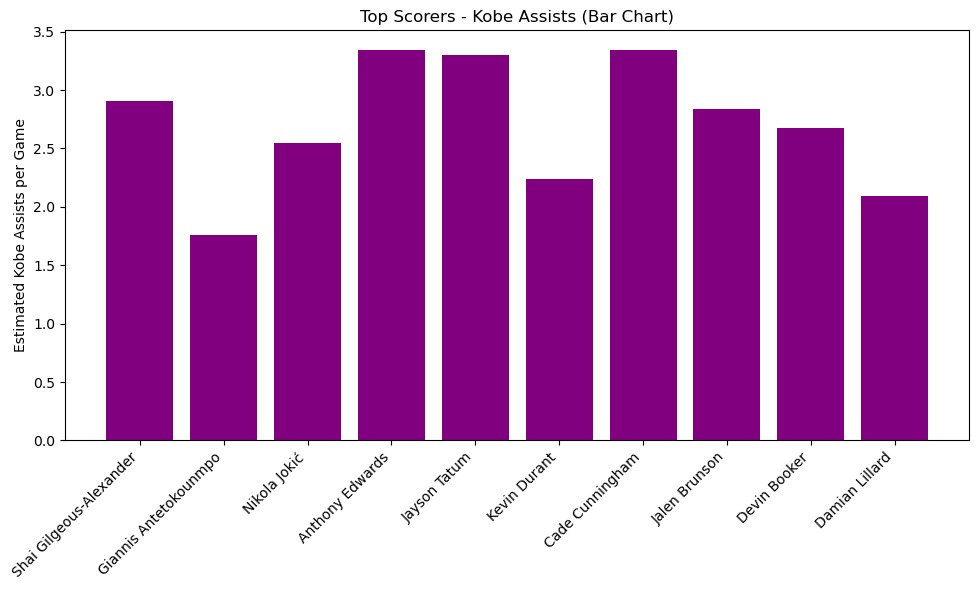

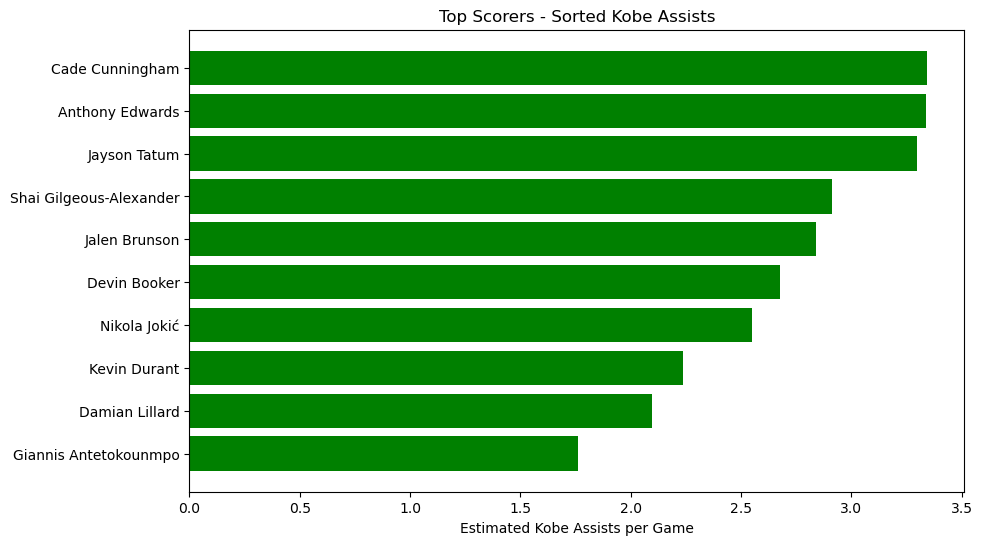

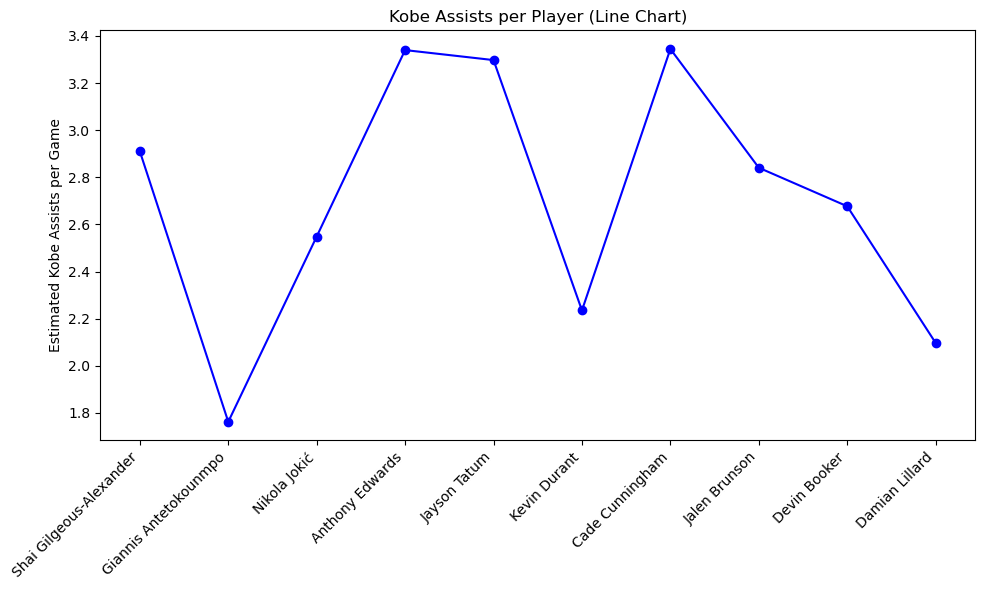

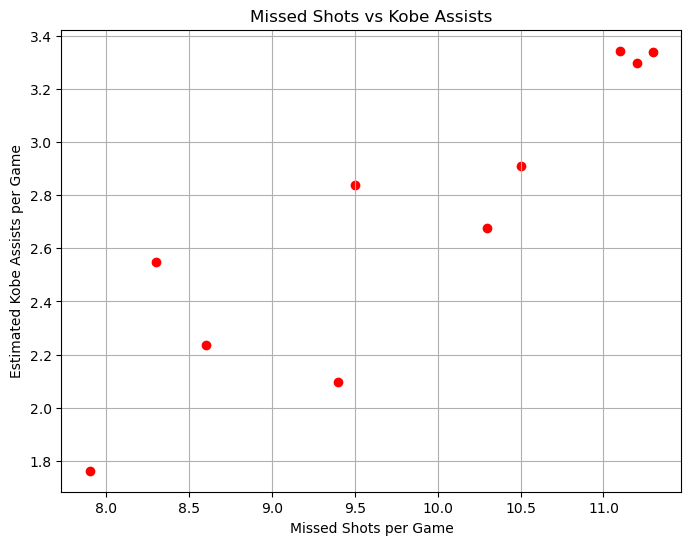

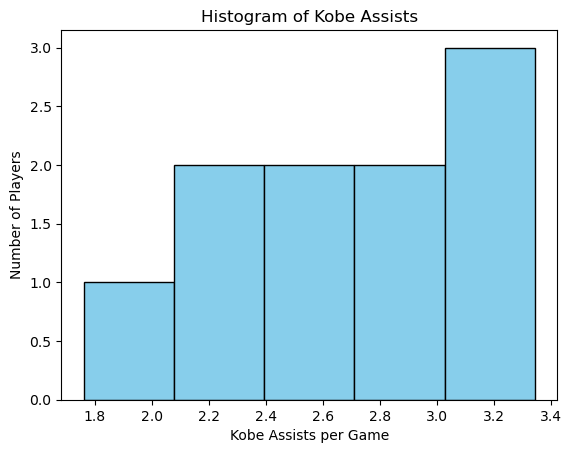

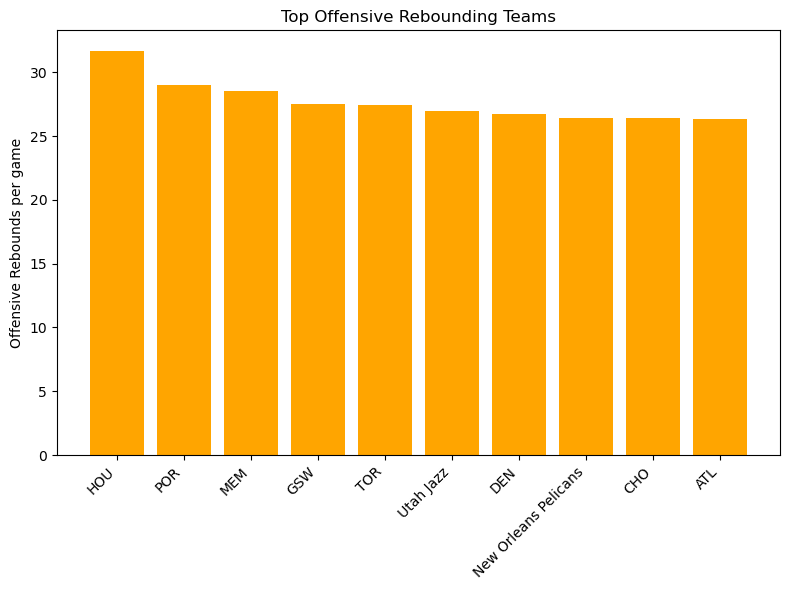

Exiting program.


In [42]:
if __name__ == "__main__":
    main()